In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/E4/Projet\ Seq2seq

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/E4/Projet Seq2seq


In [2]:
!nvidia-smi

Mon Jul  6 20:02:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv("web-traffic-time-series-forecasting/train_1.csv")
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23045 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26391 missing from current font.
  font.set_

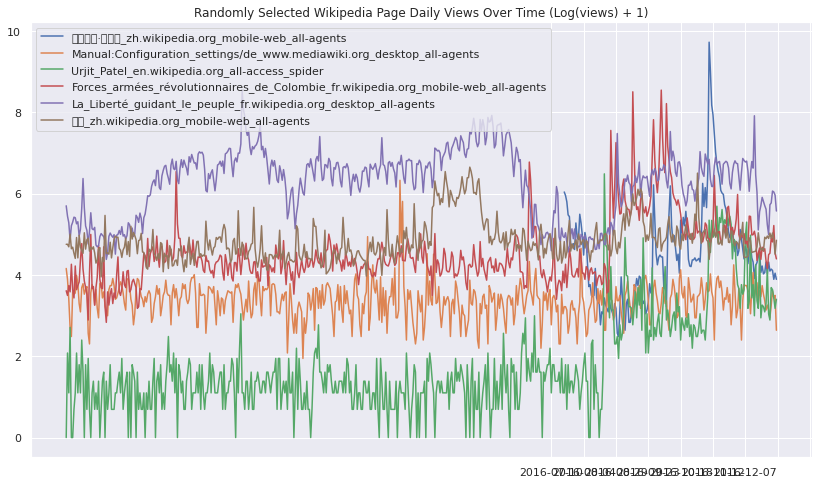

In [5]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=3)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(14,8))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
    
plot_random_series(df, 6)

In [6]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [7]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [8]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


In [9]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [10]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50), (None,  10400       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 50), ( 10400       input_4[0][0]                    
                                                                 lstm_3[0][1]               

In [11]:
first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 13s 792us/step - loss: 0.7332 - val_loss: 0.5803
Epoch 2/100
16000/16000 [==============================] - 11s 659us/step - loss: 0.6073 - val_loss: 0.4487
Epoch 3/100
16000/16000 [==============================] - 11s 657us/step - loss: 0.5207 - val_loss: 0.3904
Epoch 4/100
16000/16000 [==============================] - 11s 657us/step - loss: 0.4772 - val_loss: 0.3627
Epoch 5/100
16000/16000 [==============================] - 11s 661us/step - loss: 0.4562 - val_loss: 0.3449
Epoch 6/100
16000/16000 [==============================] - 10s 646us/step - loss: 0.4362 - val_loss: 0.3313
Epoch 7/100
16000/16000 [==============================] - 11s 660us/step - loss: 0.4251 - val_loss: 0.3212
Epoch 8/100
16000/16000 [==============================] - 11s 663us/step - loss: 0.4090 - val_loss: 0.3173
Epoch 9/100
16000/16000 [==============================] - 11s 671us/step - loss: 0.400

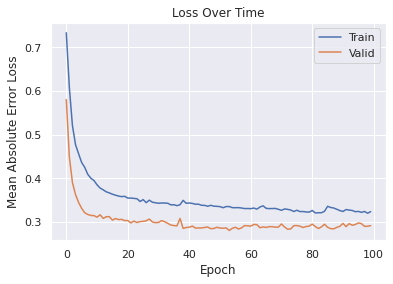

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [13]:

# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [14]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [15]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    plt.xlabel('Days')
    plt.ylabel('Number of views (Log(views) + 1)')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

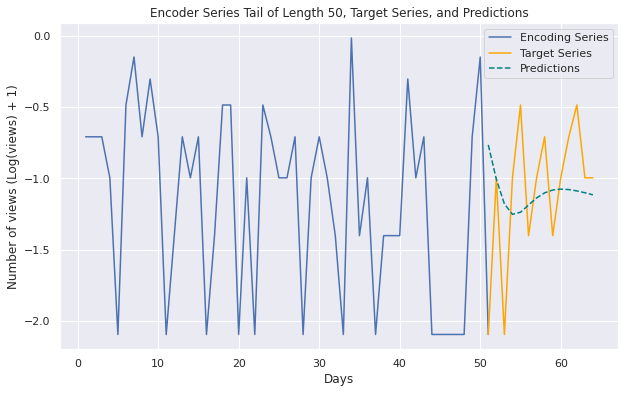

In [18]:
predict_and_plot(encoder_input_data, decoder_target_data, 160)

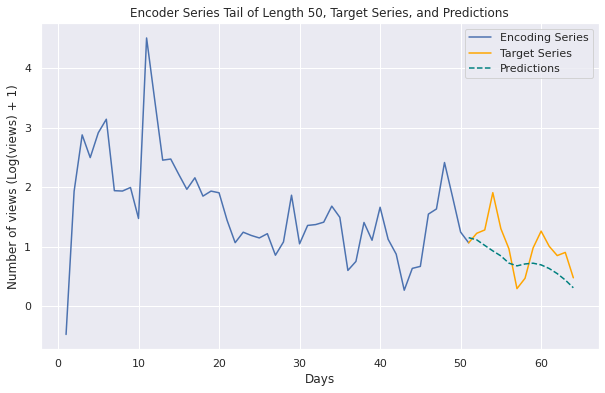

In [39]:
predict_and_plot(encoder_input_data, decoder_target_data, 6750)

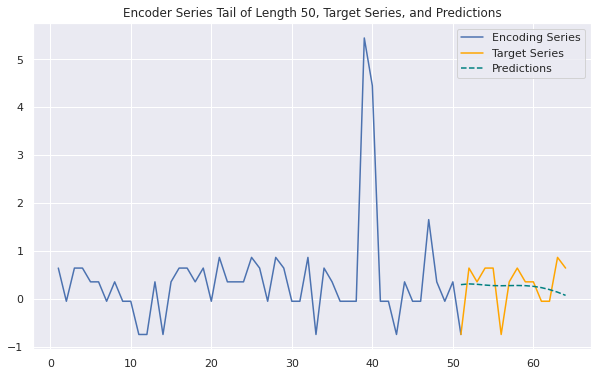

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 33000)